Training Q-learning agent...
Episode 100: Avg Reward = 98.56, Avg Steps = 12.07
Episode 200: Avg Reward = 99.26, Avg Steps = 8.42
Episode 300: Avg Reward = 99.29, Avg Steps = 8.12
Episode 400: Avg Reward = 99.27, Avg Steps = 8.26
Episode 500: Avg Reward = 99.29, Avg Steps = 8.08
Episode 600: Avg Reward = 99.29, Avg Steps = 8.08
Episode 700: Avg Reward = 99.29, Avg Steps = 8.06
Episode 800: Avg Reward = 99.29, Avg Steps = 8.06
Episode 900: Avg Reward = 99.29, Avg Steps = 8.06
Episode 1000: Avg Reward = 99.29, Avg Steps = 8.10
Episode 1100: Avg Reward = 99.29, Avg Steps = 8.14
Episode 1200: Avg Reward = 99.29, Avg Steps = 8.08
Episode 1300: Avg Reward = 99.29, Avg Steps = 8.08
Episode 1400: Avg Reward = 99.29, Avg Steps = 8.14
Episode 1500: Avg Reward = 99.30, Avg Steps = 8.04
Episode 1600: Avg Reward = 99.29, Avg Steps = 8.06
Episode 1700: Avg Reward = 99.29, Avg Steps = 8.10
Episode 1800: Avg Reward = 99.29, Avg Steps = 8.14
Episode 1900: Avg Reward = 99.30, Avg Steps = 8.04
Episode 20

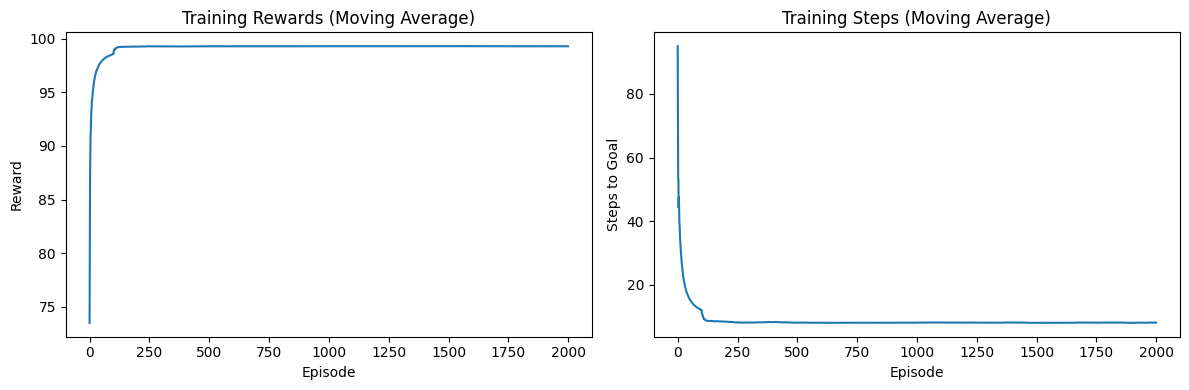


Testing trained agent...
Test completed in 8 steps with total reward: 99.30
Path: (0, 0) -> (1, 0) -> (1, 1) -> (2, 1) -> (2, 2) -> (2, 3) -> (3, 3) -> (3, 4) -> (4, 4)


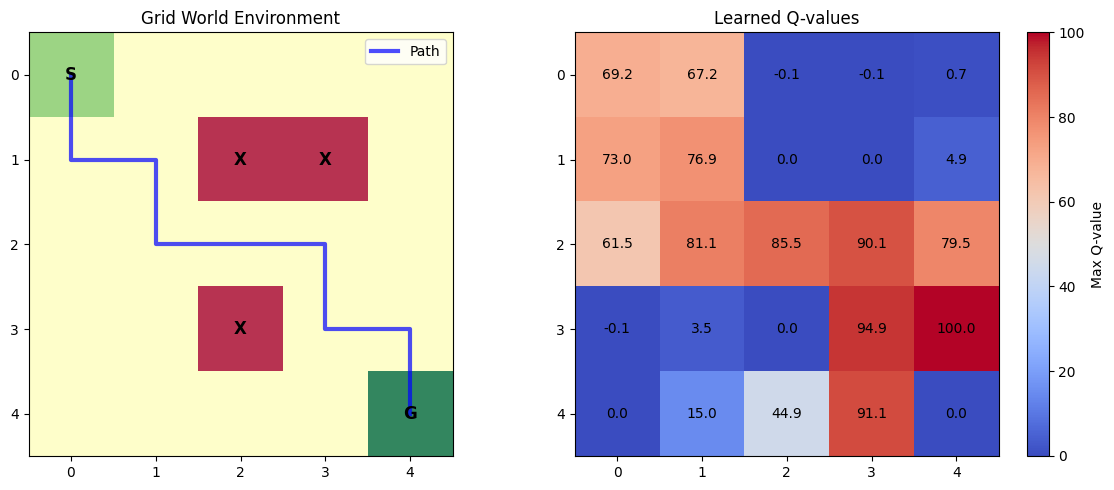


Sample Q-values:
State (0, 0): [-0.2985025  69.2304042  -0.2985025  31.35299985]
State (1, 0): [44.4032733  31.26772558 -0.1995     72.97937284]
State (0, 1): [-0.1995     67.188201   -0.17509886 -0.16575738]
State (1, 1): [37.87443934 76.92565562 38.62458188 -0.1995    ]
State (2, 0): [61.45338996 -0.10201534 -0.1995      0.08959568]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import defaultdict

class GridWorld:
    """
    A grid world environment for reinforcement learning.
    """
    def __init__(self, size=5, num_obstacles=3, start=(0, 0), goal=None):
        self.size = size
        self.start = start
        self.goal = goal if goal else (size-1, size-1)
        self.state = self.start

        # Generate random obstacles
        self.obstacles = set()
        while len(self.obstacles) < num_obstacles:
            obstacle = (random.randint(0, size-1), random.randint(0, size-1))
            if obstacle != self.start and obstacle != self.goal:
                self.obstacles.add(obstacle)

        # Action mappings: 0=up, 1=down, 2=left, 3=right
        self.actions = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }

    def reset(self):
        """Reset environment to starting state."""
        self.state = self.start
        return self.state

    def step(self, action):
        """
        Execute action and return (next_state, reward, done, info).
        """
        if action not in self.actions:
            raise ValueError("Invalid action")

        # Calculate new position
        dx, dy = self.actions[action]
        new_x = self.state[0] + dx
        new_y = self.state[1] + dy
        new_state = (new_x, new_y)

        # Check boundaries
        if (new_x < 0 or new_x >= self.size or
            new_y < 0 or new_y >= self.size or
            new_state in self.obstacles):
            # Invalid move - stay in same position
            new_state = self.state
            reward = -1  # Penalty for hitting wall/obstacle
        else:
            self.state = new_state
            if new_state == self.goal:
                reward = 100  # Large reward for reaching goal
            else:
                reward = -0.1  # Small penalty for each step

        done = (new_state == self.goal)
        return new_state, reward, done, {}

    def get_valid_actions(self, state):
        """Get list of valid actions from current state."""
        valid_actions = []
        for action in range(4):
            dx, dy = self.actions[action]
            new_x, new_y = state[0] + dx, state[1] + dy
            if (0 <= new_x < self.size and 0 <= new_y < self.size and
                (new_x, new_y) not in self.obstacles):
                valid_actions.append(action)
        return valid_actions

class QLearningAgent:
    """
    Q-learning agent for grid world navigation.
    """
    def __init__(self, env, alpha=0.1, gamma=0.95, epsilon=0.1):
        self.env = env
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate

        # Initialize Q-table as defaultdict
        self.q_table = defaultdict(lambda: np.zeros(4))

    def choose_action(self, state):
        """
        Choose action using epsilon-greedy policy.
        """
        if random.uniform(0, 1) < self.epsilon:
            # Explore: choose random valid action
            valid_actions = self.env.get_valid_actions(state)
            return random.choice(valid_actions) if valid_actions else 0
        else:
            # Exploit: choose action with highest Q-value
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        """
        Update Q-table using Q-learning formula.
        """
        current_q = self.q_table[state][action]
        max_future_q = np.max(self.q_table[next_state])

        # Q-learning update rule[12][14]
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[state][action] = new_q

    def train(self, episodes=1000, decay_epsilon=True):
        """
        Train the agent using Q-learning.
        """
        rewards_per_episode = []
        steps_per_episode = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            steps = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)

                self.update_q_table(state, action, reward, next_state)

                total_reward += reward
                steps += 1
                state = next_state

                if done or steps > 200:  # Max steps to prevent infinite loops
                    break

            rewards_per_episode.append(total_reward)
            steps_per_episode.append(steps)

            # Decay epsilon for less exploration over time
            if decay_epsilon:
                self.epsilon = max(0.01, self.epsilon * 0.995)

            # Print progress
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(rewards_per_episode[-100:])
                avg_steps = np.mean(steps_per_episode[-100:])
                print(f"Episode {episode+1}: Avg Reward = {avg_reward:.2f}, Avg Steps = {avg_steps:.2f}")

        return rewards_per_episode, steps_per_episode

    def get_policy(self):
        """
        Extract learned policy from Q-table.
        """
        policy = {}
        for state in self.q_table:
            policy[state] = np.argmax(self.q_table[state])
        return policy

def visualize_grid(env, agent=None, path=None):
    """
    Visualize the grid world environment.
    """
    fig, axes = plt.subplots(1, 2 if agent else 1, figsize=(12, 5))
    if not agent:
        axes = [axes]

    # Create grid representation
    grid = np.zeros((env.size, env.size))

    # Mark obstacles
    for obs in env.obstacles:
        grid[obs] = -1

    # Mark goal
    grid[env.goal] = 1

    # Mark start
    grid[env.start] = 0.5

    # Plot environment
    axes[0].imshow(grid, cmap='RdYlGn', alpha=0.8)
    axes[0].set_title('Grid World Environment')

    # Add labels
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) == env.start:
                axes[0].text(j, i, 'S', ha='center', va='center', fontsize=12, fontweight='bold')
            elif (i, j) == env.goal:
                axes[0].text(j, i, 'G', ha='center', va='center', fontsize=12, fontweight='bold')
            elif (i, j) in env.obstacles:
                axes[0].text(j, i, 'X', ha='center', va='center', fontsize=12, fontweight='bold')

    # Plot path if provided
    if path:
        path_x = [p[1] for p in path]
        path_y = [p[0] for p in path]
        axes[0].plot(path_x, path_y, 'b-', linewidth=3, alpha=0.7, label='Path')
        axes[0].legend()

    # Plot Q-values if agent is provided
    if agent:
        q_values = np.zeros((env.size, env.size))
        for i in range(env.size):
            for j in range(env.size):
                state = (i, j)
                if state in agent.q_table:
                    q_values[i, j] = np.max(agent.q_table[state])

        im = axes[1].imshow(q_values, cmap='coolwarm', interpolation='nearest')
        axes[1].set_title('Learned Q-values')
        plt.colorbar(im, ax=axes[1], label='Max Q-value')

        # Annotate Q-values
        for i in range(env.size):
            for j in range(env.size):
                axes[1].text(j, i, f'{q_values[i, j]:.1f}',
                           ha='center', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

def test_agent(env, agent, visualize=True):
    """
    Test the trained agent and optionally visualize the path.
    """
    state = env.reset()
    path = [state]
    total_reward = 0
    steps = 0

    while steps < 100:  # Maximum steps to prevent infinite loops
        # Choose best action (no exploration)
        action = np.argmax(agent.q_table[state])
        next_state, reward, done, _ = env.step(action)

        path.append(next_state)
        total_reward += reward
        steps += 1
        state = next_state

        if done:
            break

    if visualize:
        print(f"Test completed in {steps} steps with total reward: {total_reward:.2f}")
        print(f"Path: {' -> '.join([str(p) for p in path])}")
        visualize_grid(env, agent, path)

    return path, total_reward, steps

# Example usage and training
if __name__ == "__main__":
    # Create environment
    env = GridWorld(size=5, num_obstacles=3, start=(0, 0), goal=(4, 4))

    # Create agent
    agent = QLearningAgent(env, alpha=0.1, gamma=0.95, epsilon=0.1)

    print("Training Q-learning agent...")
    rewards, steps = agent.train(episodes=2000)

    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Moving average for smoother curves
    window = 100
    rewards_ma = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    steps_ma = [np.mean(steps[max(0, i-window):i+1]) for i in range(len(steps))]

    ax1.plot(rewards_ma)
    ax1.set_title('Training Rewards (Moving Average)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')

    ax2.plot(steps_ma)
    ax2.set_title('Training Steps (Moving Average)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps to Goal')

    plt.tight_layout()
    plt.show()

    # Test the trained agent
    print("\nTesting trained agent...")
    test_agent(env, agent)

    # Print some Q-values
    print("\nSample Q-values:")
    for state, q_vals in list(agent.q_table.items())[:5]:
        print(f"State {state}: {q_vals}")